In [1]:
import sqlite3
import pandas as pd
import itertools
from scipy.stats import mannwhitneyu
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# --- 1. Conexión a la base de datos y extracción de datos ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Filtrar filas que tengan datos en todos los índices y en "zone"
df_indices = df.dropna(subset=indices + ["zone"])

# --- 2. Comparaciones pairwise por zona ---
zones = df_indices["zone"].unique()

results = []
alpha = 0.05

for z1, z2 in itertools.combinations(zones, 2):
    for idx in indices:
        sample1 = df_indices[df_indices["zone"] == z1][idx].dropna().values
        sample2 = df_indices[df_indices["zone"] == z2][idx].dropna().values

        if len(sample1) > 0 and len(sample2) > 0:
            stat, p_val = mannwhitneyu(sample1, sample2, alternative="two-sided")
            decision = "Aceptado" if p_val >= alpha else "Rechazado"
            results.append({
                "zone1": z1,
                "zone2": z2,
                "feature": idx,
                "statistic": stat,
                "p_value": p_val,
                "decision": decision,
                "alpha": alpha
            })
            logging.info(f"{idx}: Comparación {z1} vs {z2} -> p_value = {p_val:.4f} => {decision}")

# Convertir a DataFrame y ordenar
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="p_value").reset_index(drop=True)

logging.info("Resultados de los contrastes Mann–Whitney por zonas:")
logging.info("\n" + results_df.to_string())

# --- 3. Guardar resultados en la base de datos ---
conn = sqlite3.connect(db_path)
cur = conn.cursor()

create_table_query = """
CREATE TABLE IF NOT EXISTS mann_whitney_zone_results (
    zone1 TEXT,
    zone2 TEXT,
    feature TEXT,
    statistic REAL,
    p_value REAL,
    decision TEXT,
    alpha REAL
);
"""
cur.execute(create_table_query)
conn.commit()

results_df.to_sql("mann_whitney_zone_results", conn, if_exists="replace", index=False)
conn.close()

logging.info("Resultados guardados en la tabla 'mann_whitney_zone_results'.")

2025-04-03 20:57:17,488 - INFO - ACI: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,529 - INFO - ADI: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,572 - INFO - AEI: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,617 - INFO - BIO: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,659 - INFO - NDSI: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,704 - INFO - H: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,751 - INFO - AR: Comparación Matorral vs Vera -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,784 - INFO - ACI: Comparación Matorral vs Marisma -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,815 - INFO - ADI: Comparación Matorral vs Marisma -> p_value = 0.0000 => Rechazado
2025-04-03 20:57:17,849 - INFO - AEI: Comparación Matorral vs Marisma -> p_value = 0.0000 => Rec

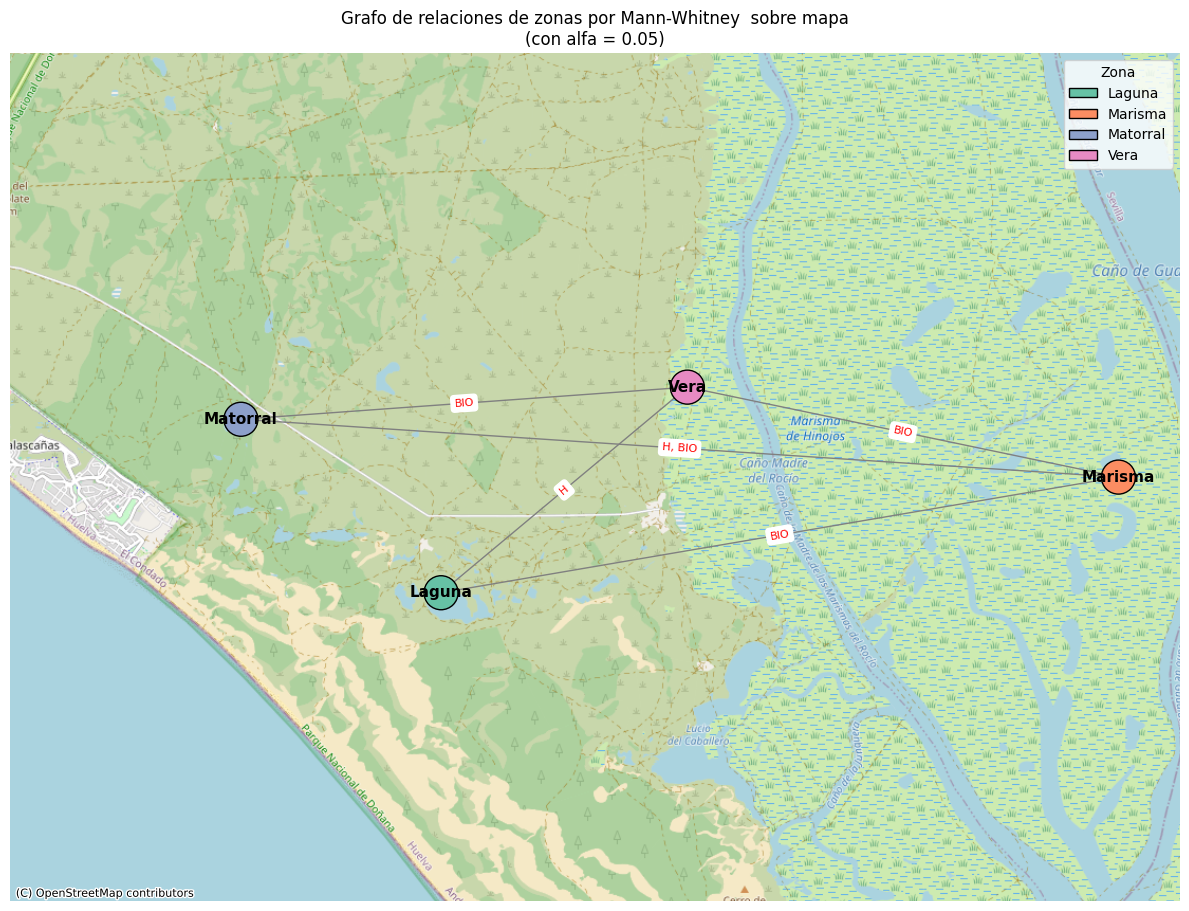

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import pandas as pd
import sqlite3
import geopandas as gpd
import contextily as ctx
import logging

# --- 1. Extraer datos de la base de datos ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)

df_mw = pd.read_sql_query("SELECT * FROM mann_whitney_results WHERE decision = 'Aceptado'", conn)
df_meta = pd.read_sql_query("SELECT recorder, name, zone, lat, lon FROM recorders WHERE recorder IS NOT 'AM22'", conn)
conn.close()

# Quitar duplicados por grabadora
df_zones = df_meta.drop_duplicates(subset=["recorder"])

# Guardar límites del mapa original (basado en grabadoras)
gdf_nodes = gpd.GeoDataFrame(df_zones, geometry=gpd.points_from_xy(df_zones["lon"], df_zones["lat"]), crs="EPSG:4326")
gdf_nodes = gdf_nodes.to_crs(epsg=3857)
original_bounds = gdf_nodes.total_bounds  # [xmin, ymin, xmax, ymax]

# Obtener coordenadas promedio por zona
zone_centers = df_zones.groupby("zone")[["lat", "lon"]].mean().reset_index()

# --- 2. Crear grafo por zonas ---
G = nx.Graph()

# Añadir nodos con posición promedio
for _, row in zone_centers.iterrows():
    G.add_node(row["zone"], pos=(row["lon"], row["lat"]))

# Mapeo de grabadoras a zonas
recorder_to_zone = dict(zip(df_zones["recorder"], df_zones["zone"]))

# Crear aristas entre zonas si grabadoras conectadas pertenecen a zonas distintas
for _, row in df_mw.iterrows():
    z1 = recorder_to_zone.get(row["recorder1"])
    z2 = recorder_to_zone.get(row["recorder2"])
    if z1 and z2 and z1 != z2:
        if G.has_edge(z1, z2):
            G[z1][z2]["features"].append(row["feature"])
        else:
            G.add_edge(z1, z2, features=[row["feature"]])

# Agregar etiquetas con features
for u, v, data in G.edges(data=True):
    data["label"] = ", ".join(data["features"])

# --- 3. Crear GeoDataFrame de zonas y proyectar ---
gdf_zones = gpd.GeoDataFrame(
    zone_centers, geometry=gpd.points_from_xy(zone_centers["lon"], zone_centers["lat"]), crs="EPSG:4326"
)
gdf_zones = gdf_zones.to_crs(epsg=3857)
pos_proj = dict(zip(gdf_zones["zone"], zip(gdf_zones.geometry.x, gdf_zones.geometry.y)))

# --- 4. Dibujar grafo proyectado sobre mapa ---
plt.figure(figsize=(12, 10))
ax = plt.gca()

# Colores pastel por zona
palette = sns.color_palette("Set2", n_colors=len(G.nodes()))
zone_colors = dict(zip(G.nodes(), palette))

# Nodos
nx.draw_networkx_nodes(
    G, pos_proj,
    node_color=[zone_colors[z] for z in G.nodes()],
    node_size=600, edgecolors='black', ax=ax
)

# Etiquetas de zonas
nx.draw_networkx_labels(G, pos_proj, labels={z: z for z in G.nodes()}, font_size=11, font_weight='bold', ax=ax)

# Aristas
nx.draw_networkx_edges(G, pos_proj, edge_color='gray', ax=ax)

# Etiquetas de aristas
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos_proj, edge_labels=edge_labels, font_color='red', font_size=8, ax=ax)

# Usar los mismos límites del mapa que el grafo de grabadoras
ax.set_xlim(original_bounds[0], original_bounds[2])
ax.set_ylim(original_bounds[1], original_bounds[3])
ax.set_aspect('equal')

# Mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_zones.crs, zoom=13)

# Leyenda por zona
legend_elements = [Patch(facecolor=color, edgecolor='black', label=zone) for zone, color in zone_colors.items()]
plt.legend(handles=legend_elements, title="Zona", loc="best")

plt.title("Grafo de relaciones de zonas por Mann-Whitney  sobre mapa\n(con alfa = 0.05)")
plt.axis("off")
plt.tight_layout()
plt.show()